In [1]:
import numpy as np
from tensorflow import keras
from scipy.io import loadmat
import os
from os import path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
keras.__version__

'2.2.4-tf'

In [3]:
import os 
current_path = os.getcwd()
os.chdir(current_path)

In [4]:
current_path

'C:\\Users\\COLDD03\\Dropbox\\xing_overlap\\latest_code'

In [5]:
## import images 
import cv2
#input1 = np.array(cv2.imread('test_overlapped_data//test_overlapped_data//FOV8//lens_4_foc_3.jpg'))
#input1 = cv2.cvtColor(input1, cv2.COLOR_RGB2BGR)
#input = np.array(input1)

#print(input.shape)



In [6]:
#initializer = keras.initializers.HeNormal()

def make_cnn_model(image_size=(201, 201, 3), classes=2, summarize=True):
    input_layer = keras.layers.Input(shape=image_size)
    # block 0: conv-> strided_conv
    x = keras.layers.Conv2D(16, 3, padding='same', activation='relu')(input_layer)
    x = keras.layers.Conv2D(16, 3, strides=2, padding='same', activation='relu')(x)
    # block 1: conv-> strided_conv
    x = keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(x)
    # block 2: conv-> strided_conv
    x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    # block 3: conv-> strided_conv
    x = keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = keras.layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
    # block 4: flatten -> FC -> layer_norm -> FC -> out
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation='relu')(x)

    #x = keras.layers.BatchNormalization()(x)

    output = keras.layers.Dense(classes, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)
    if summarize:
        model.summary()
    return model

In [8]:
model = make_cnn_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 201, 201, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 201, 201, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 101, 101, 16)      2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 101, 101, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 51, 51, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 51, 51, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 64)        36928 

In [9]:
## import model
from tensorflow.keras.models import load_model
#del model  # deletes the existing model,if you have already delete it just # it
# load
model.load_weights('9_18_test_n4_brightaug_uint8_Lrelu_weights.hdf5') # b: 6_18_n1_n32_Lrelu_weights; a: 6_13_n1_new_weights

In [10]:
## preprocess the input image
# normalization

def Norm_img(overlapped_images):
    img1 = (overlapped_images) / 255 # why 512 = 256*2 = 2^9
    img2 = np.clip(img1, 0.0, 1.0)
    img3 = np.int0(255*img2).astype(np.float32)/255 - 0.5
    return img3

#normed_img = Norm_img(input)

In [11]:
input1 = np.array(cv2.imread(os.path.join(current_path,'9_12_original_data', 'tFOV'+str(2), 'lens_4_foc_3.jpg')))[200:700,750:1250]

In [12]:
os.path.join(current_path,'9_12_original_data', 'tFOV'+str(2), 'lens_4_foc_3.jpg')

'C:\\Users\\COLDD03\\Dropbox\\xing_overlap\\latest_code\\9_12_original_data\\tFOV2\\lens_4_foc_3.jpg'

In [13]:
input1.shape

(500, 500, 3)

In [14]:
import cv2
from matplotlib import pyplot as plt
import time

from matplotlib import axes

def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    #start = time.time()
    for y in range(0, image.shape[0], stepSize[1]):
        #print(y, time.time()-start)
        
        for x in range(0, image.shape[1], stepSize[0]):
            # yield the current window
            
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0],:])

In [15]:
#input1 = np.array(cv2.imread(os.path.join(current_path,'9_12_original_data', 'tFOV'+str(2), 'lens_4_foc_3.jpg')))

In [16]:
#sliding_win_res = sliding_window(input1, (1, 1), (201, 201))

In [17]:
#list(sliding_win_res)

(1080, 1920, 3)
before results


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



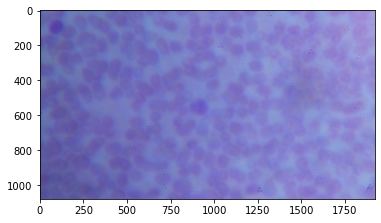

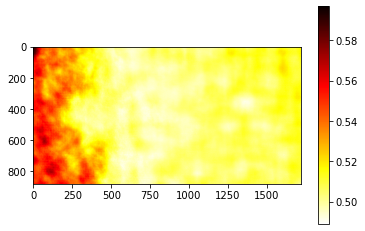

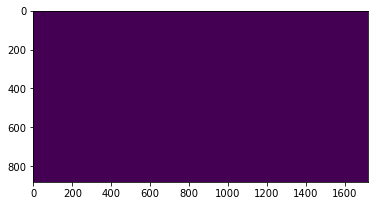

time cost 5784.404654502869 s


In [20]:
# return sliding window's predict results
def get_results(image, stepSize, windowSize):
    timer = 0
    results= []
    for (x, y, window) in sliding_window(image, stepSize, windowSize):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != windowSize[1] or window.shape[1] != windowSize[0]:
            continue
        slice = image[y:y + windowSize[1], x:x + windowSize[0],:]
        timer = timer+1
       # print(['working: ',str(timer)])
        #put our saved model here
            #slice_ = np.expand_dims(np.expand_dims(slice, axis=0), axis=-1)
        #print(slice.shape)
        slice_ = np.expand_dims(slice, axis=0)
        #print(slice.shape)
        # if timer<20:
        #   plt.figure()
        #   plt.imshow(slice_[0,:,:,:])
        #print(slice_.shape)
        y = model(slice_, training = False)
        #print(y) # [0, 1]
        y_ = np.argmax(y)
        #print(y, y_)
        results.append(
            
            
            
            y[0][1])
    return results


if __name__ == '__main__':
    #change this line to the way to get the testdata
    # image = cv2.imread('testdata.png')
    time_start=time.time()
    for img_num in range(5,6,1):
        fov_num = img_num+1
        #for N = 1:
        #input1 = np.array(cv2.imread('9_10_original_data//overlapped_test_Data//tFOV'+str(fov_num)+'//lens_4_foc_3.jpg'))
        #for N > 1:
        input1 = np.array(cv2.imread(os.path.join(current_path,'9_12_original_data', 'overlay', 'tFOV'+str(fov_num), 'N = 4_2.jpg')))[:,:]
        #'9_10_original_data//overlapped_test_Data//overlay//tFOV'+str(fov_num)+'//N = 2.jpg'
        input1 = cv2.cvtColor(input1, cv2.COLOR_RGB2BGR)
        input = np.array(input1)
        
        
        print(input.shape)
        
        normed_img = Norm_img(input)
        
        image = normed_img
    
        timer = 0;

        w = image.shape[1]
        h = image.shape[0]
        
        (winW, winH) = (201,201)
        stepSize = (1,1)
        print("before results")
        results=get_results(image, stepSize, windowSize=(winW, winH))
        print(results)
        heat_r = np.array(results)
    # hr = heat_r.reshape(73,87)
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # im = ax.imshow(hr, cmap=plt.cm.hot_r)
    # plt.colorbar(im)
    # plt.show()
    #hr = heat_r.reshape(h-95,w-95)
    
####### no threshold #######
       
        plt.figure()
        plt.imshow(input1)
        plt.show()
        save_name = '9_12_b_n3_whole_hm_tFOV'+str(fov_num)+'_cropped.png'
        plt.imsave(save_name, input1)

        hr = heat_r.reshape(h-200,w-200)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        im = ax.imshow(hr, cmap=plt.cm.hot_r)
        plt.colorbar(im)
        plt.show()
        save_name = '9_12_b_n3_whole_hm_tFOV'+ str(fov_num)+'.png'
        plt.imsave(save_name, hr)
        
        
        k = hr.copy()
        k=np.where(k>0.99, k, 0)
# k = np.maximum(heatmap[:,:,2],255*0.9)
        plt.figure()
        plt.imshow(k,vmin=0,vmax=1)
        plt.show()
        save_name = '9_12_b_n3_whole_hm_tFOV'+str(fov_num)+'_thre0.99.png'
        plt.imsave(save_name, k)
        time_end=time.time()
        print('time cost',time_end-time_start,'s')


In [19]:
hr





array([[0.49463362, 0.49401346, 0.4940615 , ..., 0.4984228 , 0.4980419 ,
        0.49851152],
       [0.49480566, 0.4946002 , 0.4932694 , ..., 0.49863213, 0.49798203,
        0.49831298],
       [0.49503765, 0.49430013, 0.49350604, ..., 0.49972662, 0.49951217,
        0.4991873 ],
       ...,
       [0.49887675, 0.49816164, 0.49741605, ..., 0.4991662 , 0.49794707,
        0.4987468 ],
       [0.49834523, 0.49941093, 0.49954996, ..., 0.498861  , 0.49896124,
        0.4980796 ],
       [0.49804854, 0.49792436, 0.50149834, ..., 0.4993885 , 0.49988368,
        0.49933502]], dtype=float32)

(1080, 1920, 3)
before results


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



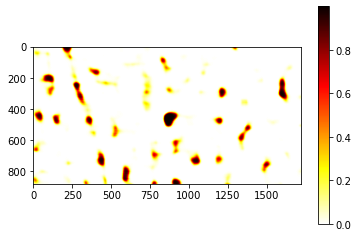

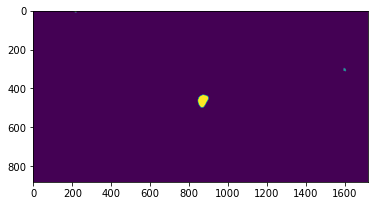

time cost 5536.389806985855 s
(1080, 1920, 3)
before results


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



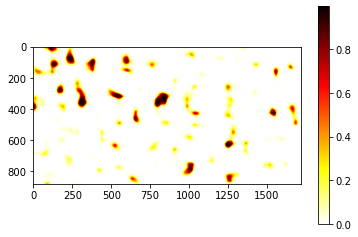

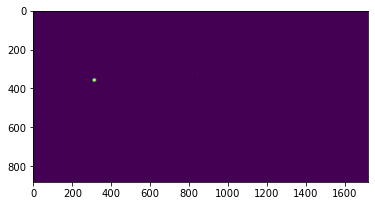

time cost 11010.388912677765 s
(1080, 1920, 3)
before results


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



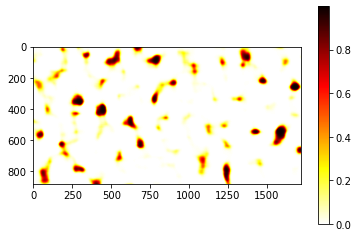

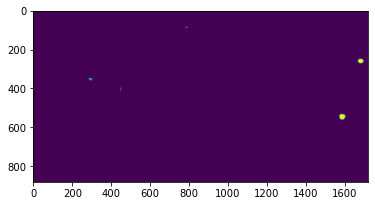

time cost 16530.76904129982 s
(1080, 1920, 3)
before results


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



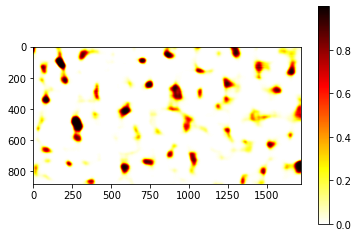

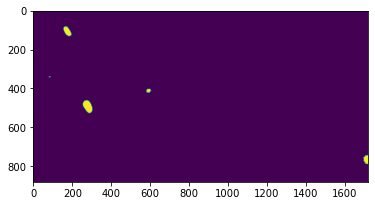

time cost 22029.954627275467 s
(1080, 1920, 3)
before results


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



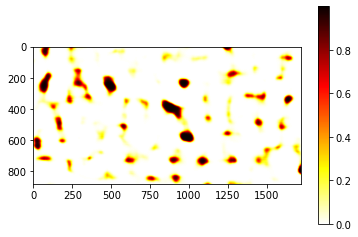

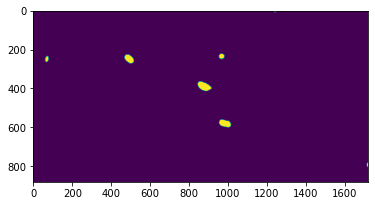

time cost 27547.82838511467 s
(1080, 1920, 3)
before results


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



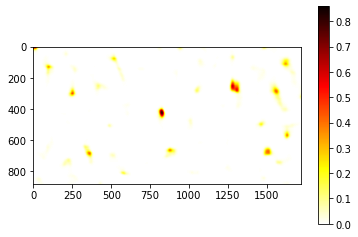

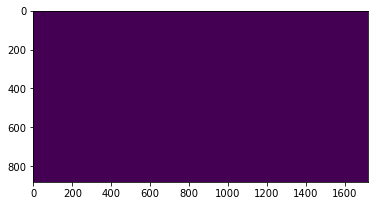

time cost 33055.6499414444 s
(1080, 1920, 3)
before results


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



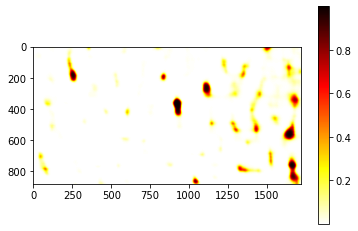

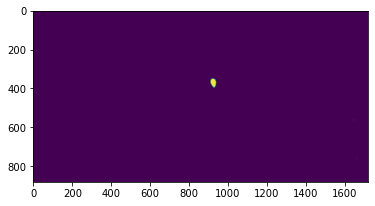

time cost 38785.51857972145 s


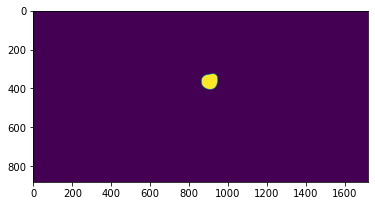

In [16]:
k = hr.copy()
k=np.where(k>0.99, k, 0)
# k = np.maximum(heatmap[:,:,2],255*0.9)
plt.figure()
plt.imshow(k,vmin=0,vmax=1)
plt.show()
save_name = '9_10_b_n1_whole_hm_tFOV'+str(fov_num)+'_thre0.99.png'
plt.imsave(save_name, k)


In [197]:
normed_img.shape

(1080, 1920, 3)

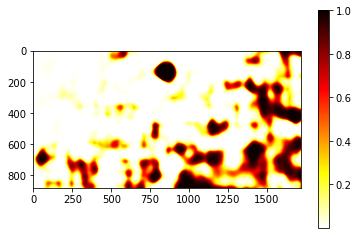

time cost 5017.6320815086365 s


In [198]:
import cv2
from matplotlib import pyplot as plt
import time

from matplotlib import axes

def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize[1]):
        for x in range(0, image.shape[1], stepSize[0]):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0],:])


# return sliding window's predict results
def get_results(image, stepSize, windowSize):
    timer = 0
    results= []
    for (x, y, window) in sliding_window(image, stepSize, windowSize):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != windowSize[1] or window.shape[1] != windowSize[0]:
            continue
        slice = image[y:y + windowSize[1], x:x + windowSize[0],:]
        timer = timer+1
       # print(['working: ',str(timer)])
        #put our saved model here
            #slice_ = np.expand_dims(np.expand_dims(slice, axis=0), axis=-1)
        #print(slice.shape)
        slice_ = np.expand_dims(slice, axis=0)
        #print(slice.shape)
        # if timer<20:
        #   plt.figure()
        #   plt.imshow(slice_[0,:,:,:])
        #print(slice_.shape)
        y = model.predict(slice_)
        #print(y) # [0, 1]
        y_ = np.argmax(y)
        results.append(y[0][1])
    return results

if __name__ == '__main__':
    #change this line to the way to get the testdata
    # image = cv2.imread('testdata.png')
    time_start=time.time()
    image = normed_img
    
    timer = 0;

    w = image.shape[1]
    h = image.shape[0]
    
    (winW, winH) = (201,201)
    stepSize = (1,1)

    results=get_results(image, stepSize, windowSize=(winW, winH))
    heat_r = np.array(results)
    # hr = heat_r.reshape(73,87)
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # im = ax.imshow(hr, cmap=plt.cm.hot_r)
    # plt.colorbar(im)
    # plt.show()
    #hr = heat_r.reshape(h-95,w-95)
    
####### no threshould #######
    hr = heat_r.reshape(h-200,w-200)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(hr, cmap=plt.cm.hot_r)
    plt.colorbar(im)
    plt.show()
    save_name = '9_1_b_n1_whole_hm_tFOV8.png'
    plt.imsave(save_name, hr)
    time_end=time.time()
    print('time cost',time_end-time_start,'s')

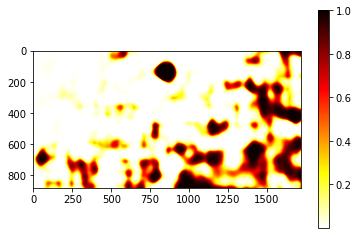

In [199]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(hr, cmap=plt.cm.hot_r)
plt.colorbar(im)
plt.show()

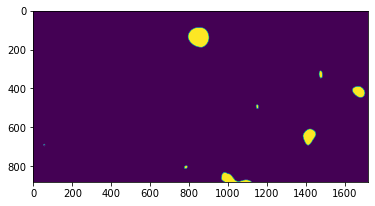

In [200]:
k = hr.copy()
k=np.where(k>0.99, k, 0)
# k = np.maximum(heatmap[:,:,2],255*0.9)
plt.figure()
plt.imshow(k,vmin=0,vmax=1)
plt.show()
save_name = '9_1_b_n1_whole_hm_tFOV8_thre0.99.png'
plt.imsave(save_name, k)